In [22]:
import numpy as np

# Operators from Qiskit
from qiskit.quantum_info import SparsePauliOp
# Qiskit circuit library
from qiskit.circuit.library import EfficientSU2

# Qiskit from IBM
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Import SPSA from module
from spsa import minimize_spsa

import matplotlib.pyplot as plt

In [4]:
# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [18]:
# Define backends
use_real = False

if use_real:
    backend = service.backend('ibm_cleveland')
else:
    backend = service.backend('ibmq_qasm_simulator')

In [7]:
hamiltonian = SparsePauliOp.from_list([('YZ', 0.39793742484318045),
                                     ('ZI', -0.39793742484318045),
                                     ('ZZ', -0.01128010425623538),
                                     ('XX', 0.18093119978423156)])

print (hamiltonian)

SparsePauliOp(['YZ', 'ZI', 'ZZ', 'XX'],
              coeffs=[ 0.39793742+0.j, -0.39793742+0.j, -0.0112801 +0.j,  0.1809312 +0.j])


In [8]:
H_mat = hamiltonian.to_matrix()
np.linalg.eigvalsh(H_mat)

array([-0.70278562, -0.45302961,  0.45302961,  0.70278562])

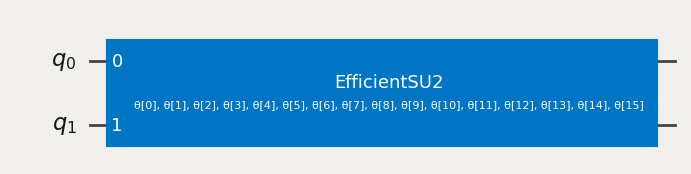

In [9]:
ansatz = EfficientSU2(2)

ansatz.draw('mpl')

In [10]:
import numpy as np
from scipy.optimize import OptimizeResult

def minimize_spsa(func, x0, args=(), maxiter=100,
                  a=1.0, alpha=0.602, c=0.2, gamma=0.101,
                  callback=None):
    """
    Minimization of scalar function of one or more variables using simultaneous
    perturbation stochastic approximation (SPSA).

    Parameters:
        func (callable): The objective function to be minimized.

                          ``fun(x, *args) -> float``

                          where x is an 1-D array with shape (n,) and args is a
                          tuple of the fixed parameters needed to completely 
                          specify the function.

        x0 (ndarray): Initial guess. Array of real elements of size (n,), 
                      where ‘n’ is the number of independent variables.
      
        maxiter (int): Maximum number of iterations.  The number of function
                       evaluations is twice as many. Optional.

        a (float): SPSA gradient scaling parameter. Optional.

        alpha (float): SPSA gradient scaling exponent. Optional.

        c (float):  SPSA step size scaling parameter. Optional.
        
        gamma (float): SPSA step size scaling exponent. Optional.

        callback (callable): Function that accepts the current parameter vector
                             as input. Optional.

    Returns:
        OptimizeResult: Solution in SciPy Optimization format.

    Notes:
        See the `SPSA homepage <https://www.jhuapl.edu/SPSA/>`_ for usage and
        additional extentions to the basic version implimented here.
    """
    A = 0.01 * maxiter
    x0 = np.asarray(x0)
    x = x0

    for kk in range(maxiter):
        ak = a * (kk+1.0+A)**-alpha
        ck = c * (kk+1.0)**-gamma
        # Bernoulli distribution for randoms
        deltak =  2*np.random.randint(2, size=x.shape[0])-1
        grad = (func(x + ck*deltak, *args) - func(x - ck*deltak, *args)) / (2*ck*deltak)
        x -= ak*grad
        
        if callback is not None:
            callback(x)

    return OptimizeResult(fun=func(x, *args), x=x, nit=maxiter, nfev=2*maxiter, 
                          message='Optimization terminated successfully.',
                          success=True)

In [11]:
def cost_func(params, ansatz, hamiltonian, estimator):
        """Return estimate of energy from estimator

        Parameters:
            params (ndarray): Array of ansatz parameters
            ansatz (QuantumCircuit): Parameterized ansatz circuit
            hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
            estimator (Estimator): Estimator primitive instance

        Returns:
            float: Energy estimate
        """
        energy = estimator.run(ansatz, hamiltonian,
                               parameter_values=params).result().values[0]
        return energy

In [12]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
    """Return callback function that uses Estimator instance,
    and stores intermediate values into a dictionary.

    Parameters:
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
        callback_dict (dict): Mutable dict for storing values

    Returns:
        Callable: Callback function object
    """

    def callback(current_vector):
        """Callback function storing previous solution vector,
        computing the intermediate cost value, and displaying number
        of completed iterations and average time per iteration.

        Values are stored in pre-defined 'callback_dict' dictionary.

        Parameters:
            current_vector (ndarray): Current vector of parameters
                                      returned by optimizer
        """
        # Keep track of the number of iterations
        callback_dict["iters"] += 1
        # Set the prev_vector to the latest one
        callback_dict["prev_vector"] = current_vector
        # Compute the value of the cost function at the current vector
        # This adds an additional function evaluation
        current_cost = estimator.run(ansatz, hamiltonian,
                                     parameter_values=current_vector).result().values[0]
        callback_dict["cost_history"].append(current_cost)
        # Print to screen on single line
        print(
            "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
            end="\r",
            flush=True,
        )

    return callback

In [13]:
num_params = ansatz.num_parameters
params = 2*np.pi*np.random.random(num_params)

In [21]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

session = Session(backend=backend)
estimator = Estimator(session=session)
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

res = minimize_spsa(cost_func, x0=params,
                    args=(ansatz, hamiltonian, estimator),
                    callback=callback,
                    maxiter=100)
session.close()

In [24]:
print(res)

 message: Optimization terminated successfully.
 success: True
     fun: -0.7027036570321009
       x: [ 9.992e-01  1.731e+00 ...  5.515e+00  3.452e+00]
     nit: 100
    nfev: 200


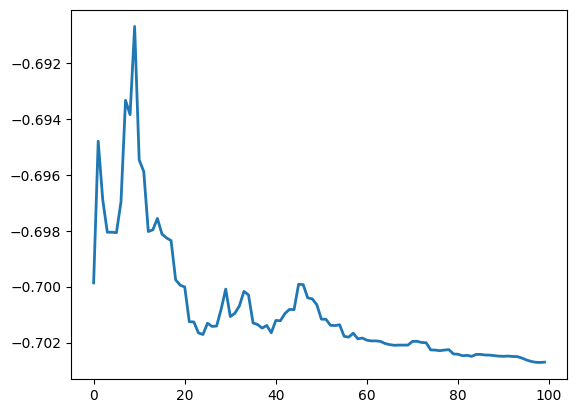

In [25]:
plt.plot(callback_dict['cost_history'], lw=2)